In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn import metrics
from itertools import combinations
from scipy.stats import pearsonr, zscore

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using.. ',device)

Using..  cpu


In [229]:
df = pd.read_csv('loans_full_schema.csv')

In [4]:
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


In [230]:
df1 = df.pop('interest_rate')
df['interest_rate'] = df1

In [ ]:
lst =[]
for col in df.columns:
  if len(df[col].unique())<3:
    lst.append(col)
lst

In [231]:
df.drop(['num_accounts_120d_past_due'], axis=1, inplace=True) #since only one value in the column

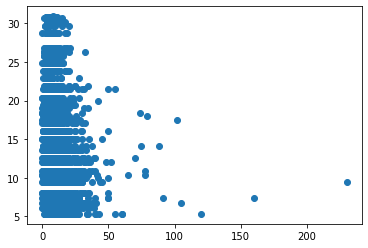

In [92]:
plt.scatter(df.annual_income/10000,df.interest_rate)
plt.show()

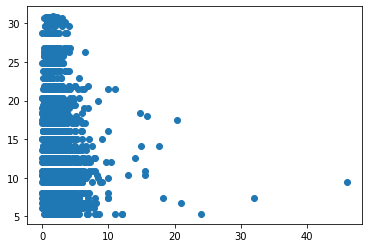

In [93]:
plt.scatter(df.annual_income/50000,df.interest_rate)
plt.show()

In [232]:
zero_col = ['emp_length','debt_to_income', 'annual_income_joint','debt_to_income_joint','months_since_last_delinq','months_since_90d_late','months_since_last_credit_inquiry']
empty_col = ['emp_title','verification_income_joint',]
df[zero_col] = df[zero_col].fillna(0)
df[empty_col] = df[empty_col].fillna('')

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   emp_title                         10000 non-null  object 
 1   emp_length                        10000 non-null  float64
 2   state                             10000 non-null  object 
 3   homeownership                     10000 non-null  object 
 4   annual_income                     10000 non-null  float64
 5   verified_income                   10000 non-null  object 
 6   debt_to_income                    10000 non-null  float64
 7   annual_income_joint               10000 non-null  float64
 8   verification_income_joint         10000 non-null  object 
 9   debt_to_income_joint              10000 non-null  float64
 10  delinq_2y                         10000 non-null  int64  
 11  months_since_last_delinq          10000 non-null  float64
 12  earli

In [233]:
num_feat = df.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(df[comb[0]], df[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.8]

In [234]:
df = df.drop(np.unique(high_corr_num[:, 1]), axis=1, errors='ignore')

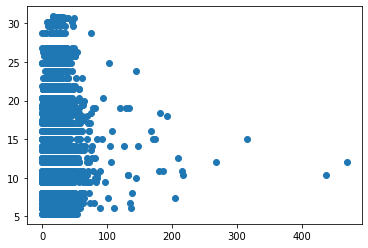

In [288]:
plt.scatter(df.debt_to_income,df.interest_rate)
plt.show()

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   emp_title                         10000 non-null  object 
 1   emp_length                        10000 non-null  float64
 2   state                             10000 non-null  object 
 3   homeownership                     10000 non-null  object 
 4   annual_income                     10000 non-null  float64
 5   verified_income                   10000 non-null  object 
 6   debt_to_income                    10000 non-null  float64
 7   annual_income_joint               10000 non-null  float64
 8   verification_income_joint         10000 non-null  object 
 9   debt_to_income_joint              10000 non-null  float64
 10  delinq_2y                         10000 non-null  int64  
 11  months_since_last_delinq          10000 non-null  float64
 12  earli

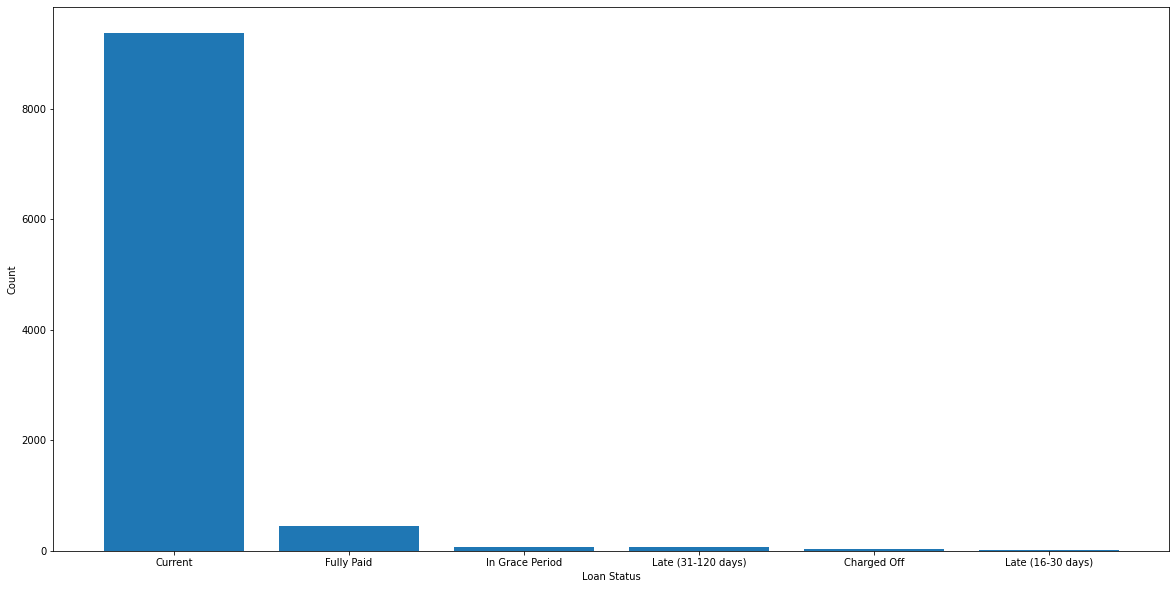

In [19]:
plt.figure(figsize=(20,10))
plt.bar(df['loan_status'].unique(),df['loan_status'].value_counts())
plt.xlabel('Loan Status')
plt.ylabel('Count')
#.bar(title="Loan Status Counts", xlabel='Loan Status', ylabel='Count', width=500, height=350)
plt.show()

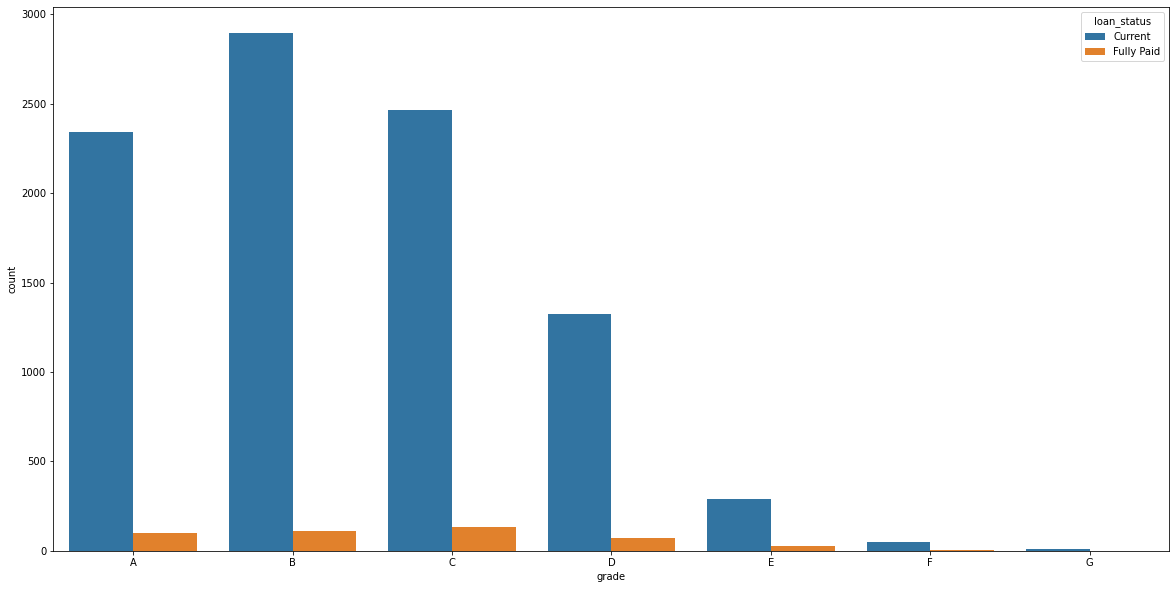

In [42]:
plt.figure(figsize=(20,10))
grade = sorted(df.grade.unique())
status = df[df['loan_status'].isin(df.loan_status.unique()[:2])]
sns.countplot(x='grade', data=status, hue='loan_status', order=grade)
plt.show()

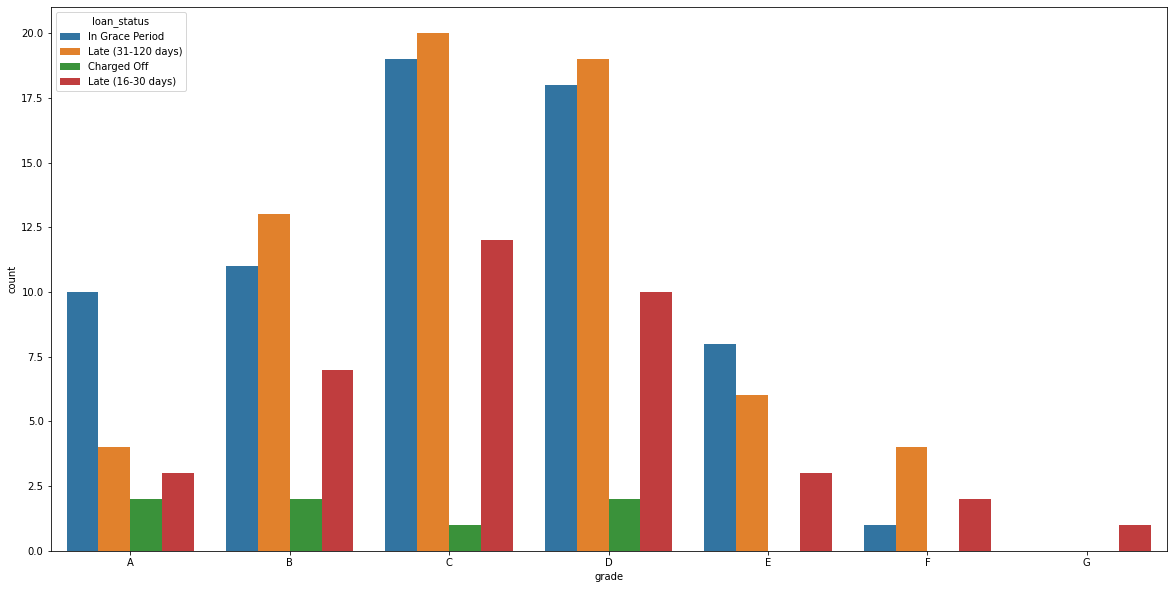

In [39]:
plt.figure(figsize=(20,10))
grade = sorted(df.grade.unique())
status = df[df['loan_status'].isin(df.loan_status.unique()[2:])]
sns.countplot(x='grade', data=status, hue='loan_status', order=grade)
plt.show()

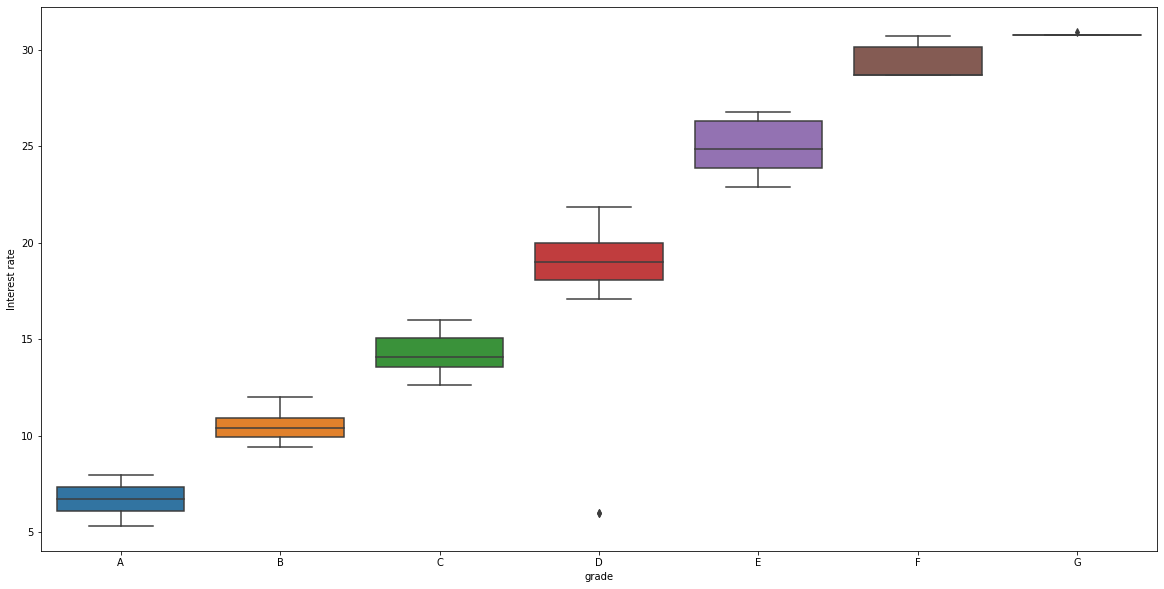

In [97]:
plt.figure(figsize=(20,10))

sns.boxplot(data=df, x='grade', y='interest_rate',order=grade)
plt.ylabel('Interest rate')
plt.show()

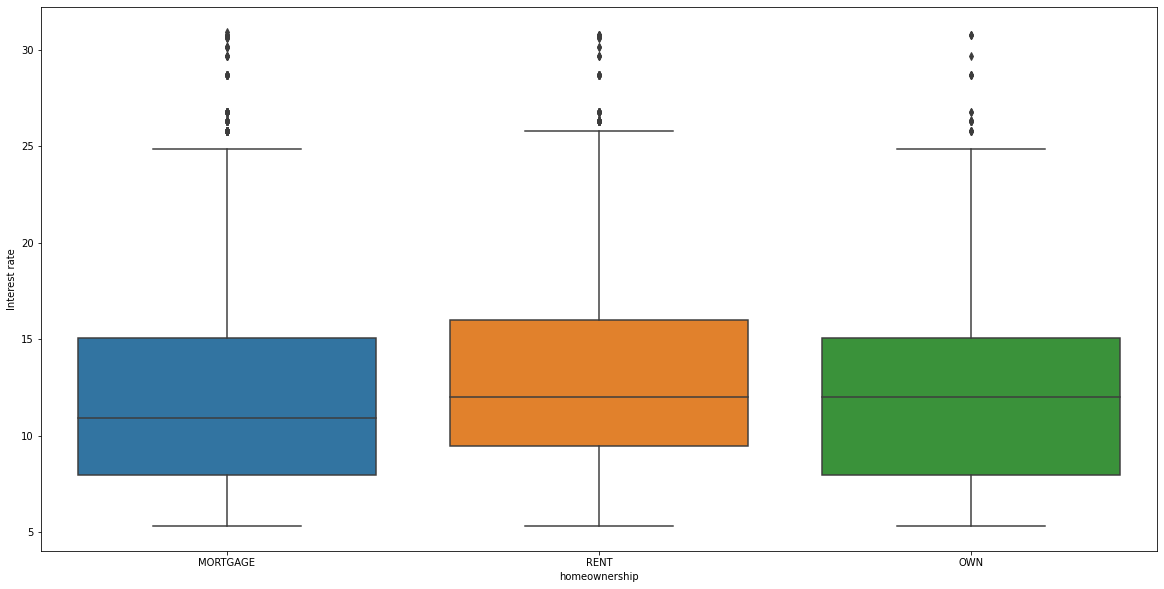

In [99]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='homeownership', y='interest_rate')
plt.ylabel('Interest rate')
plt.show()

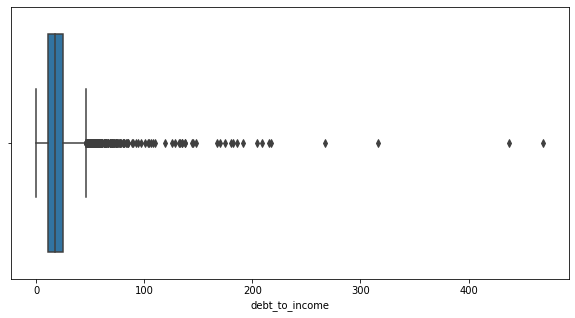

In [100]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='debt_to_income')
plt.show()

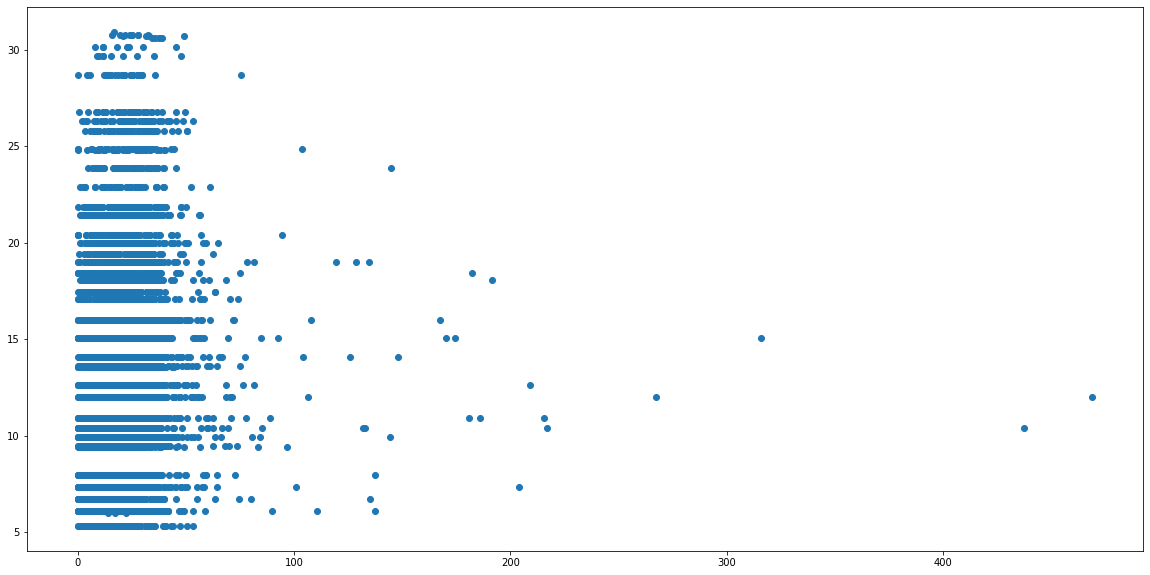

In [101]:
plt.figure(figsize=(20,10))
plt.scatter(df.debt_to_income,df.interest_rate)
plt.show()

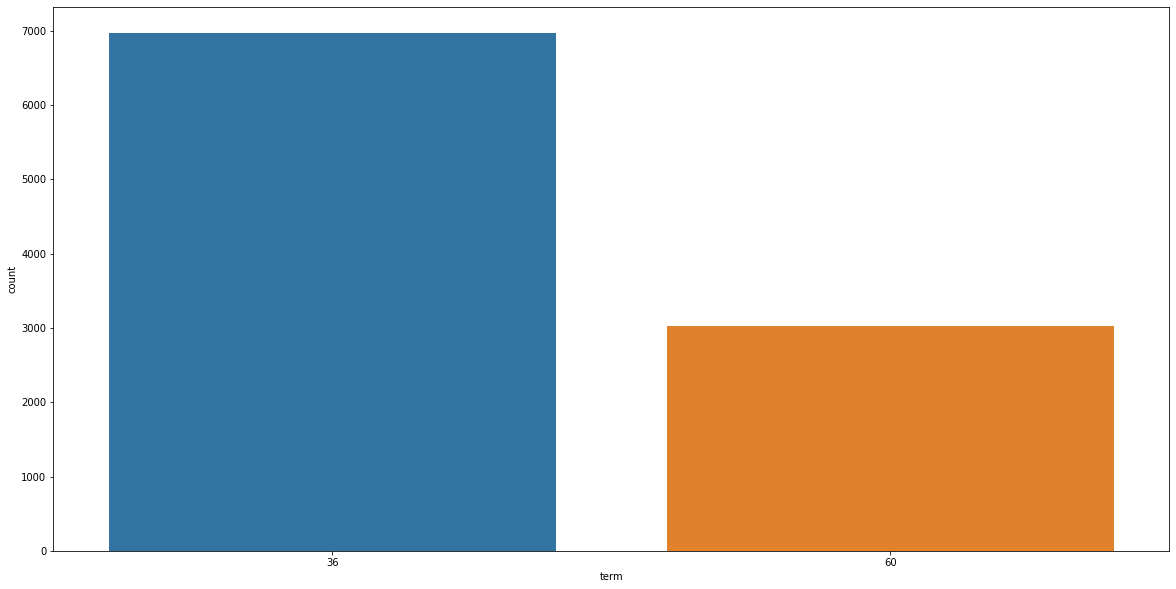

In [110]:
plt.figure(figsize=(20,10))

sns.countplot(x='term', data=df)#, hue='interest_rate')
plt.show()

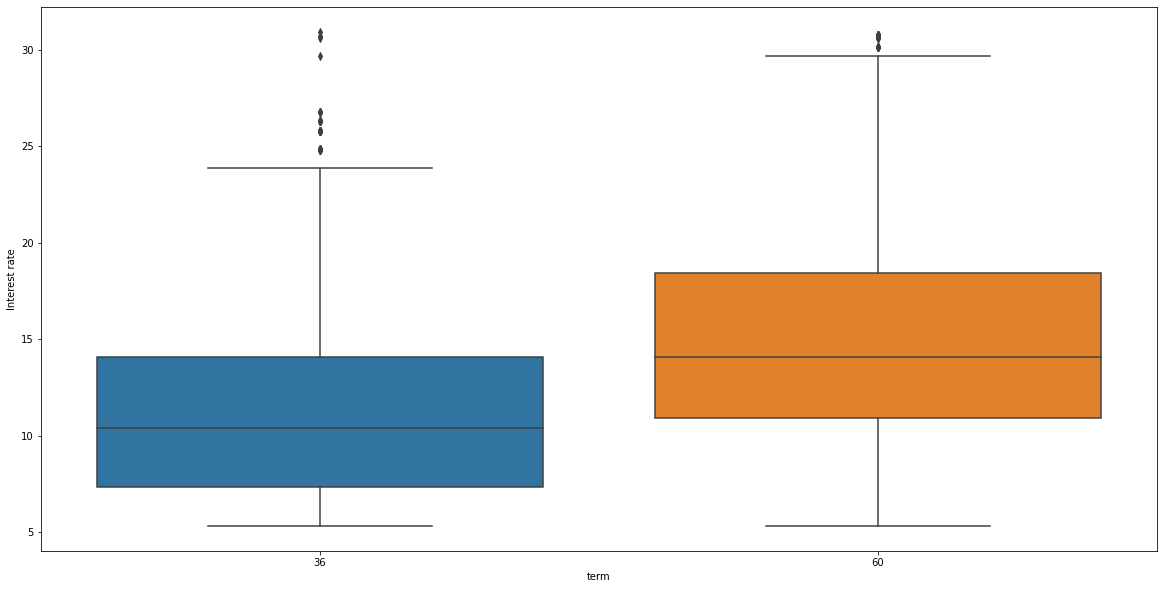

In [108]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='term', y='interest_rate')
plt.ylabel('Interest rate')
plt.show()

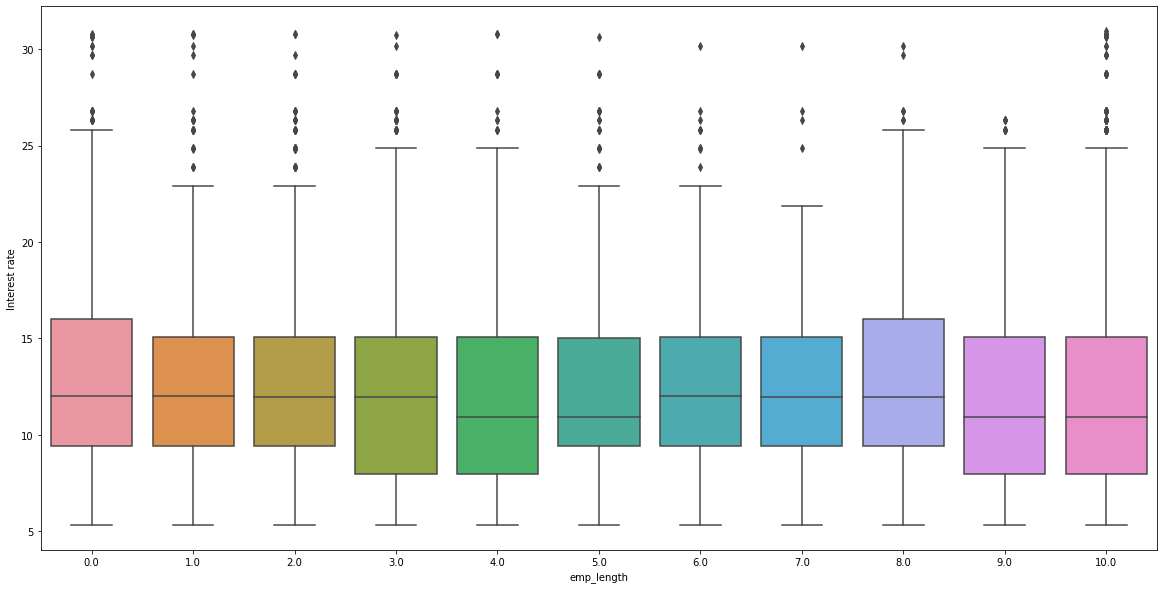

In [114]:
order = df.emp_length.unique().sort()
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='emp_length', y='interest_rate', order=order)
plt.ylabel('Interest rate')
plt.show()

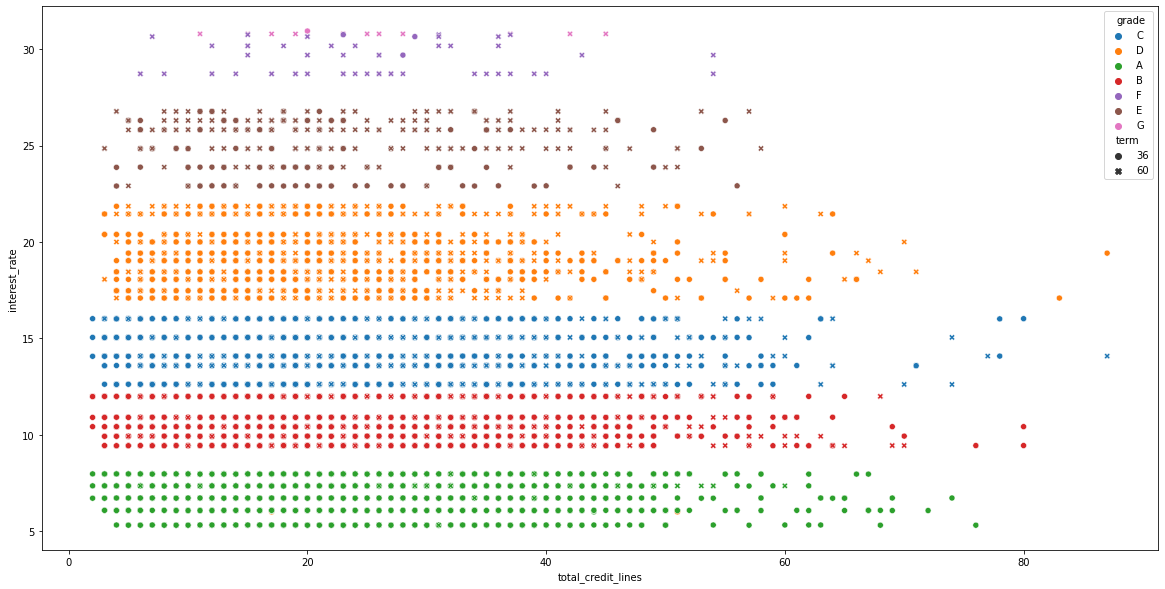

In [119]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df, x="total_credit_lines", y="interest_rate", hue="grade", style="term")
plt.show()

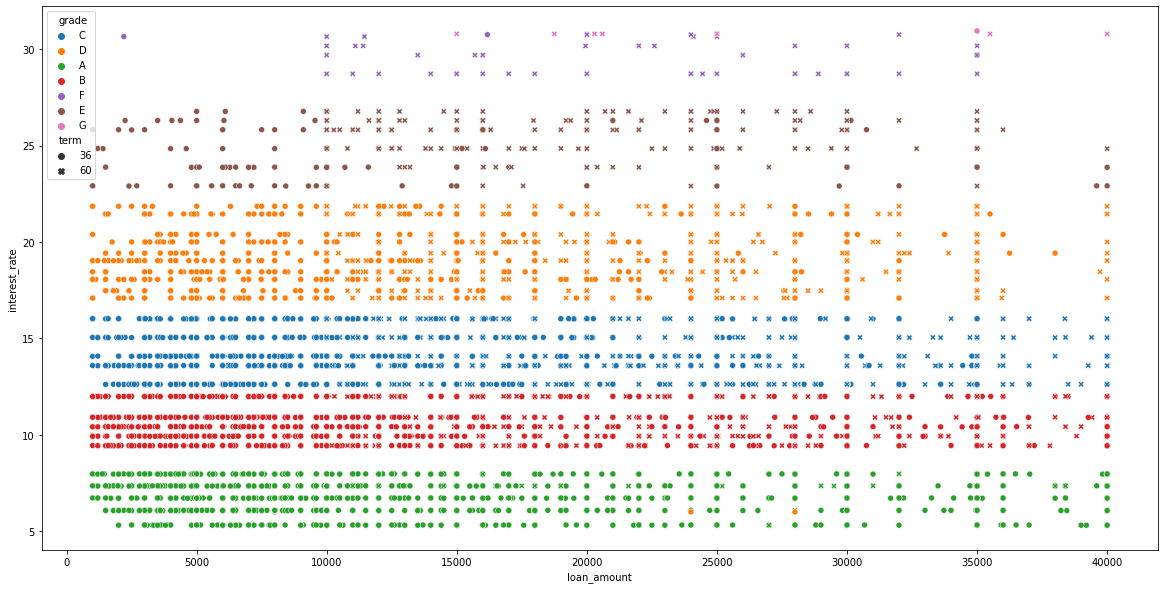

In [174]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df[df['annual_income']<1.0e6], x="loan_amount", y="interest_rate", hue="grade", style="term")
plt.show()

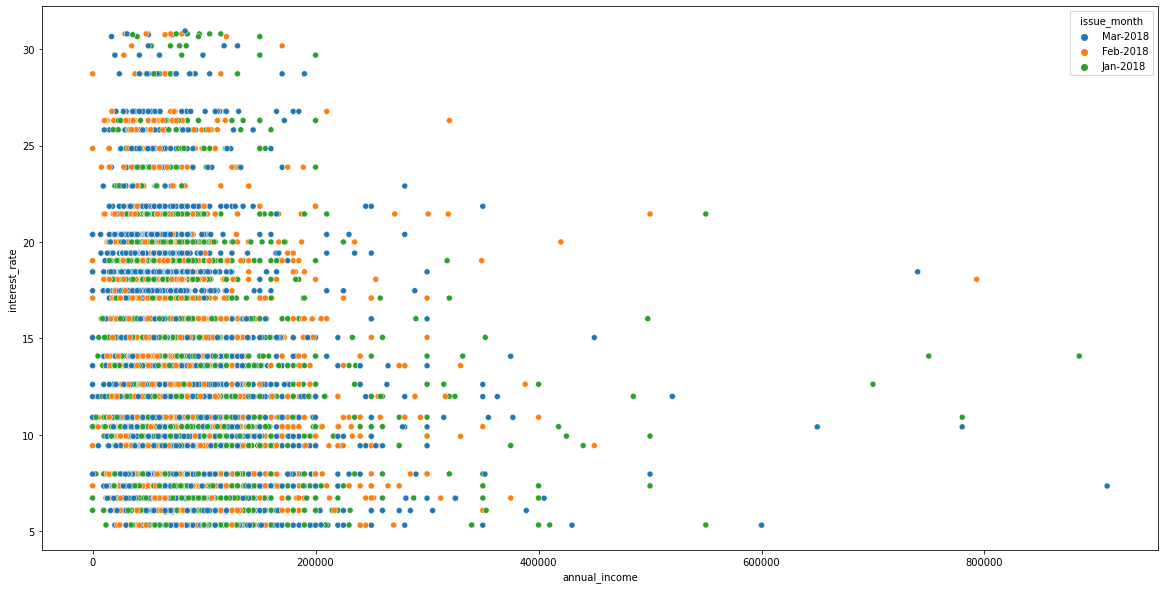

In [156]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df[df['annual_income']<1.0e6], x="annual_income", y="interest_rate", hue="issue_month")#, style="issue_month")
plt.show()

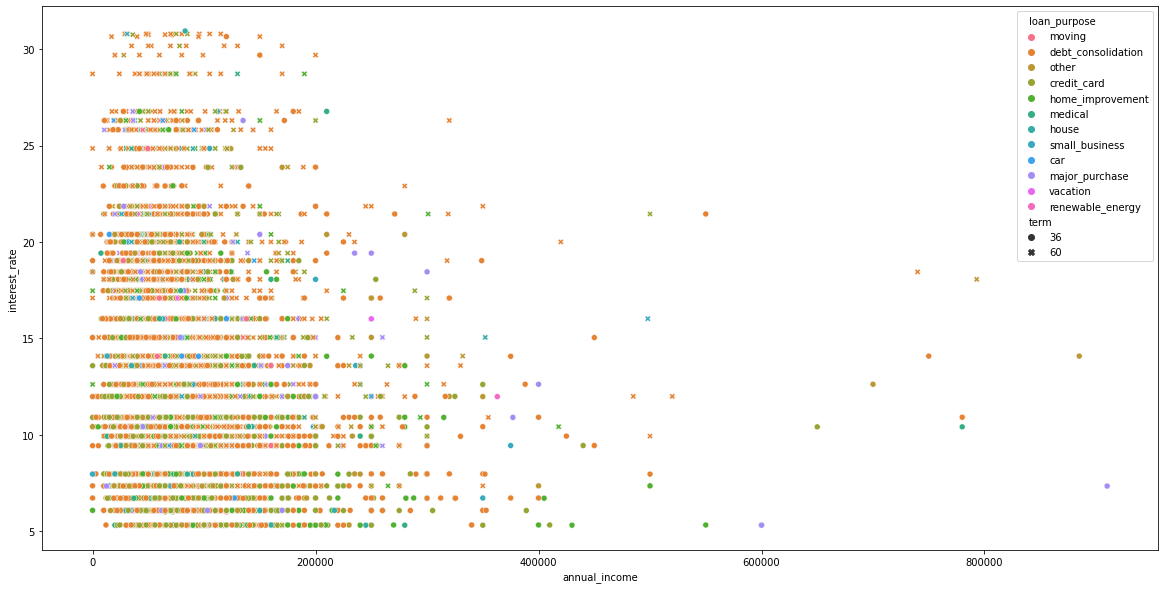

In [173]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df[(df['annual_income']<1.0e6)], x="annual_income", y="interest_rate", hue="loan_purpose", style="term")
plt.show()

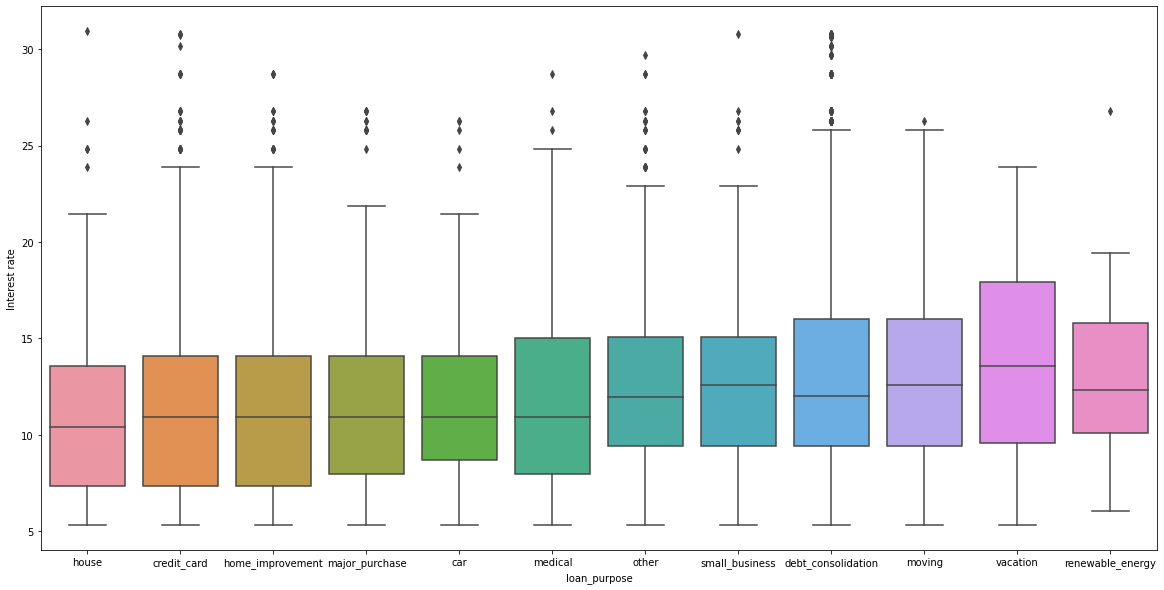

In [153]:
order = df.groupby('loan_purpose').agg({'interest_rate': ['mean']})['interest_rate'].sort_values(by='mean').index
plt.figure(figsize=(20,10))
sns.boxplot(data=df, x='loan_purpose', y='interest_rate', order=order)
plt.ylabel('Interest rate')
plt.show()

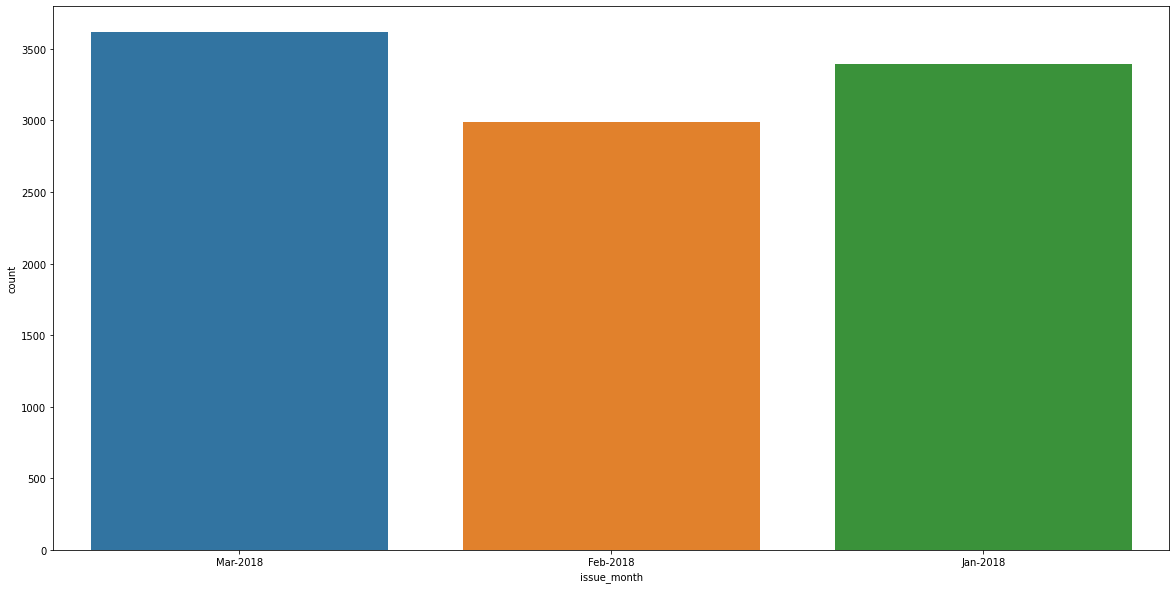

In [154]:
plt.figure(figsize=(20,10))

sns.countplot(x='issue_month', data=df)#, hue='interest_rate')
plt.show()

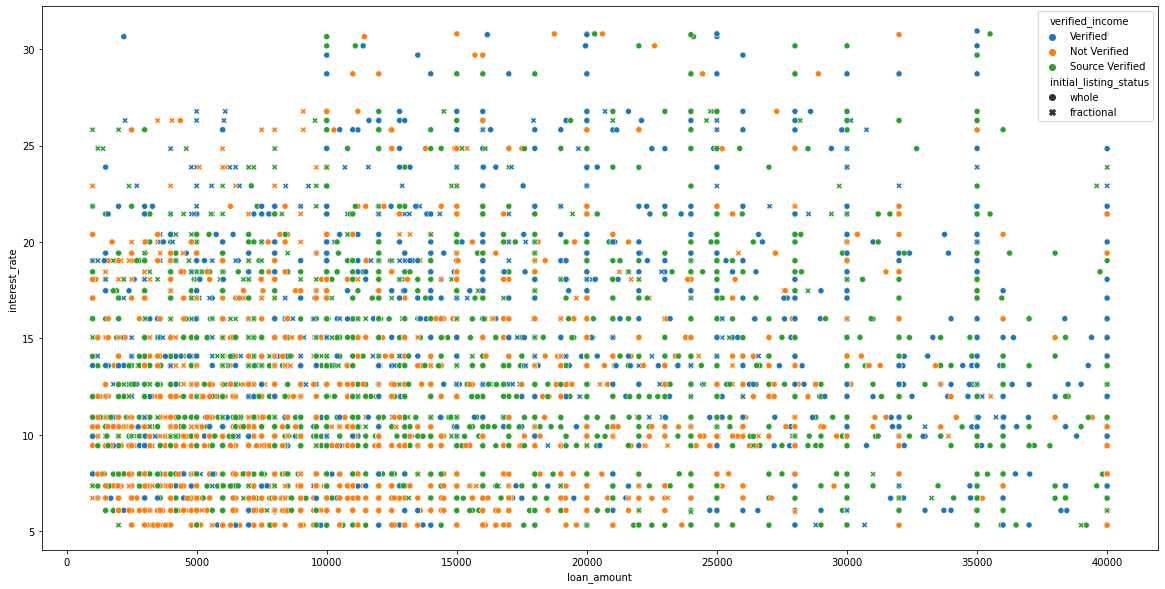

In [183]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df[df['annual_income']<0.6e6], x="loan_amount", y="interest_rate", hue="verified_income", style="initial_listing_status")
plt.show()

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   emp_title                         10000 non-null  object 
 1   emp_length                        10000 non-null  float64
 2   state                             10000 non-null  object 
 3   homeownership                     10000 non-null  object 
 4   annual_income                     10000 non-null  float64
 5   verified_income                   10000 non-null  object 
 6   debt_to_income                    10000 non-null  float64
 7   annual_income_joint               10000 non-null  float64
 8   verification_income_joint         10000 non-null  object 
 9   debt_to_income_joint              10000 non-null  float64
 10  delinq_2y                         10000 non-null  int64  
 11  months_since_last_delinq          10000 non-null  float64
 12  earli

In [235]:
#removing outliers
df = df[(df.annual_income<df.annual_income.mean()+3*df.annual_income.std())]
df = df[~((df.grade =='D') & (df.interest_rate < 10))]

In [121]:
#remove outliers

# df = df[(np.abs(zscore(df[df.select_dtypes('number').columns.values])) < 3).all(axis=1)]

In [236]:
cat_col = df.select_dtypes('object').columns.values
for col in cat_col:
  tmepdf = df[col].copy()
  s= tmepdf.value_counts()
  s = s[s<10]
  df.loc[df[col].isin(s.index), col] = ''
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col])

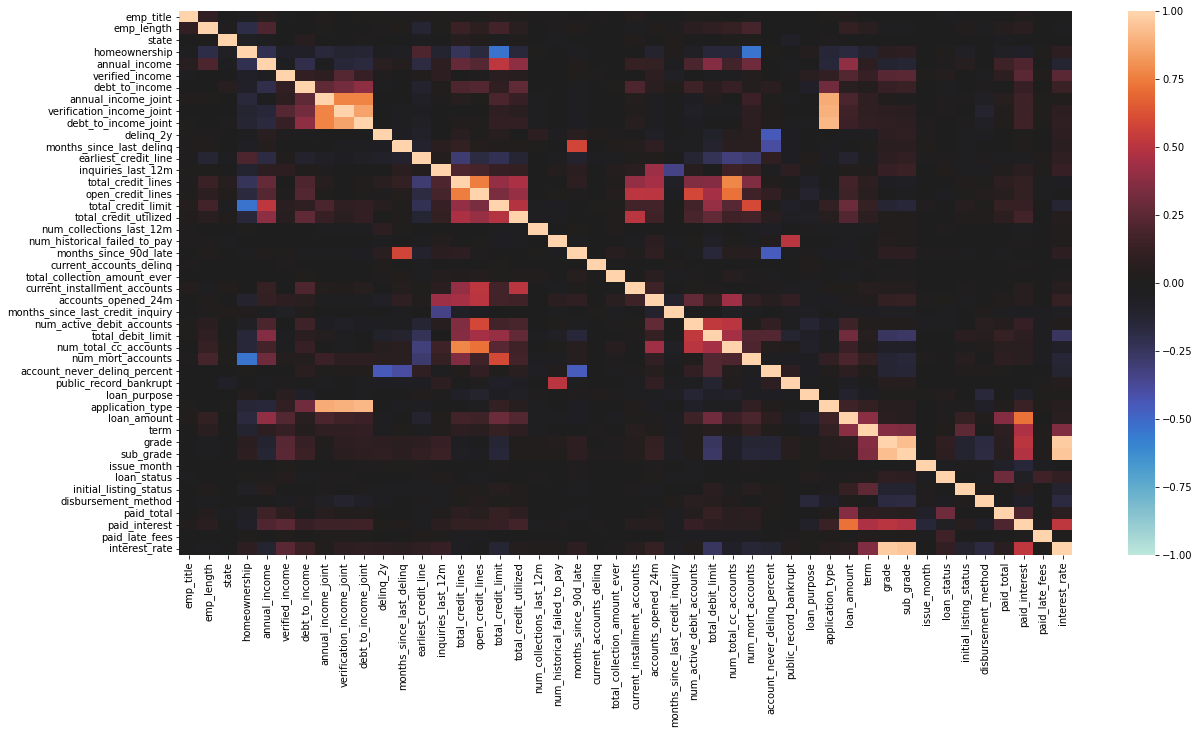

In [209]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0)
plt.show()

In [238]:

combs = np.array(list(combinations(df.columns.values[:-1], 2)))
corrs = np.array([])
for comb in combs:
    corr = pearsonr(df[comb[0]], df[comb[1]])[0]
    corrs = np.append(corrs, corr)
high_corr= combs[np.abs(corrs) >= 0.8]
df = df.drop(np.unique(high_corr[:, 0]), axis=1, errors='ignore')

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9863 entries, 0 to 9999
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   emp_title                         9863 non-null   int64  
 1   emp_length                        9863 non-null   float64
 2   state                             9863 non-null   int64  
 3   homeownership                     9863 non-null   int64  
 4   annual_income                     9863 non-null   float64
 5   verified_income                   9863 non-null   int64  
 6   debt_to_income                    9863 non-null   float64
 7   delinq_2y                         9863 non-null   int64  
 8   months_since_last_delinq          9863 non-null   float64
 9   earliest_credit_line              9863 non-null   int64  
 10  inquiries_last_12m                9863 non-null   int64  
 11  total_credit_lines                9863 non-null   int64  
 12  open_c

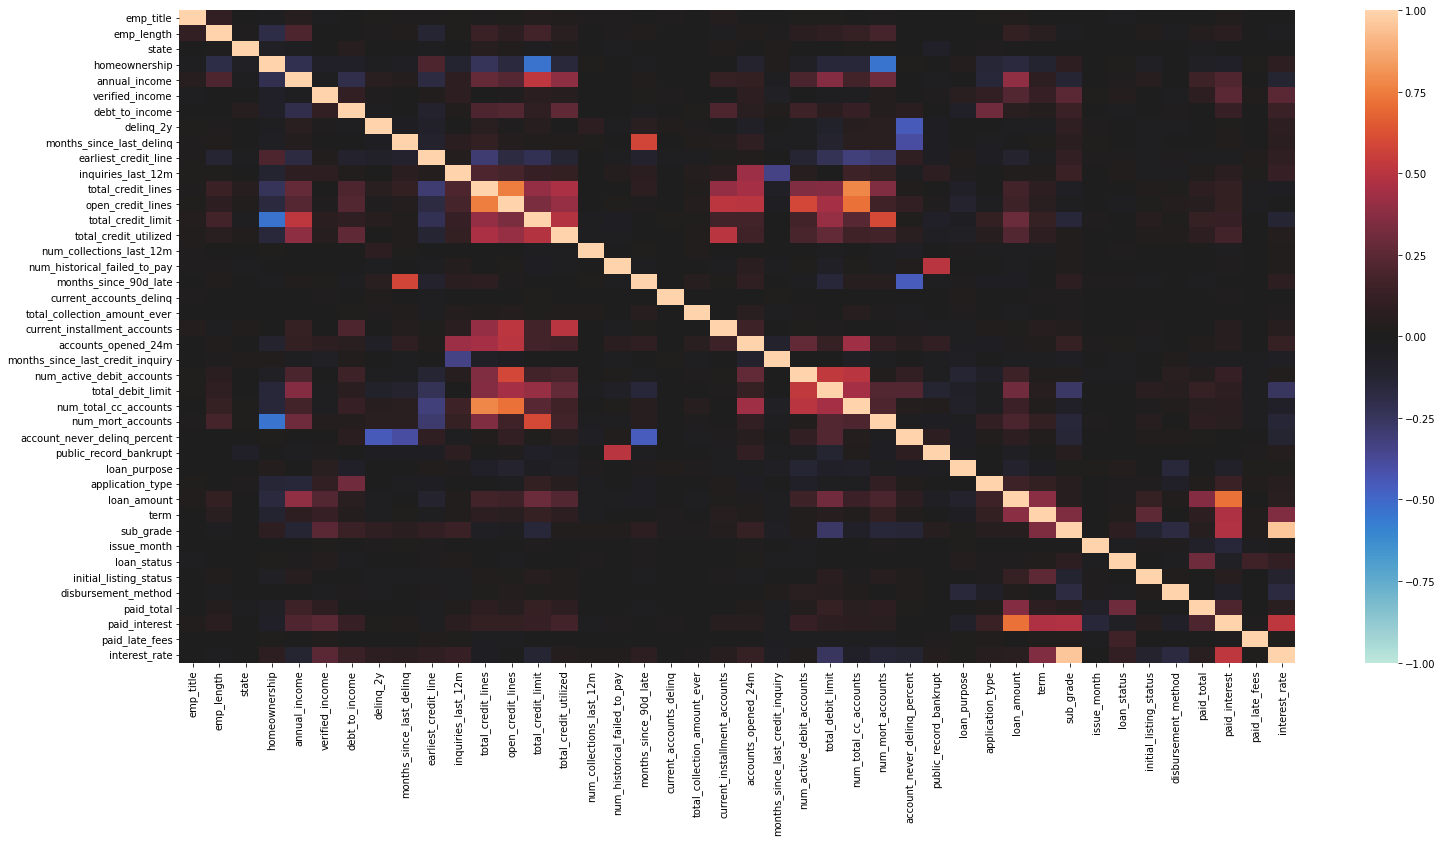

In [240]:
plt.figure(figsize=(25,12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0)
plt.show()

In [247]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1].values


In [313]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
sc = StandardScaler()
y_train = sc.fit_transform(y_train.reshape(-1,1))
y_test = sc.transform(y_test.reshape(-1,1))

In [314]:
rf = RandomForestRegressor(n_estimators=100, random_state = 42)
rf.fit(X_train, y_train.reshape(-1,))

RandomForestRegressor(random_state=42)

In [319]:
y_pred = rf.predict(X_test)
y_pred = sc.inverse_transform(y_pred.reshape(-1,1))

In [320]:
error = metrics.mean_squared_error(sc.inverse_transform(y_test), y_pred, squared=False)
print('Root Mean Squared Error: ',round(error,3))
print('Mean Absolute Error: ',round(metrics.mean_absolute_error(sc.inverse_transform(y_test), y_pred),3))

Root Mean Squared Error:  0.046
Mean Absolute Error:  0.01


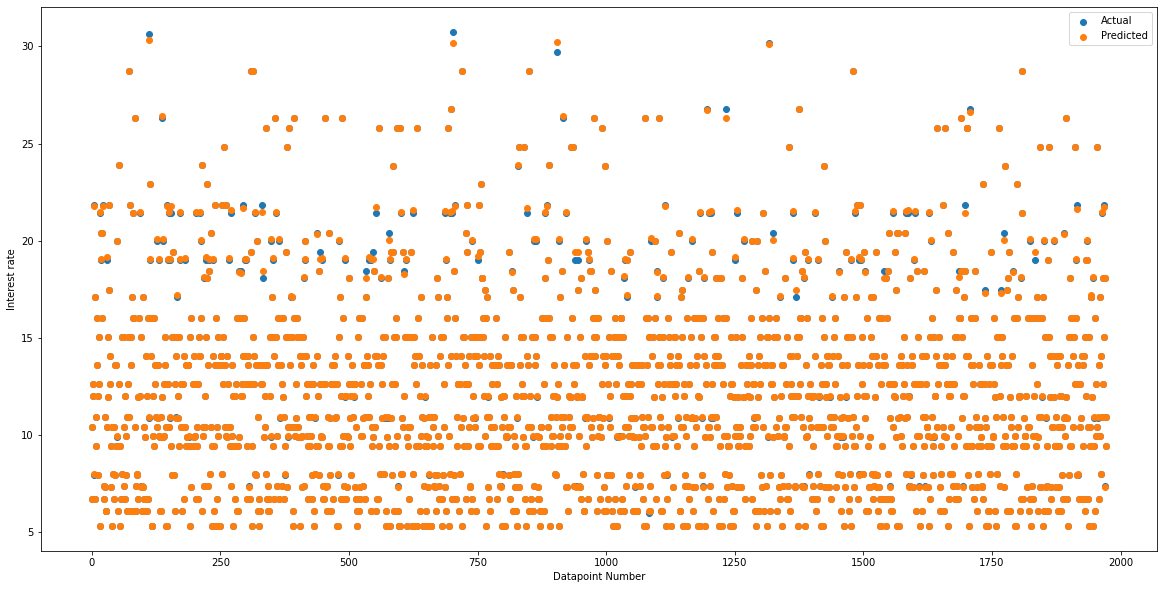

In [321]:
plt.figure(figsize=(20,10))
plt.scatter(y=sc.inverse_transform(y_test),x=range(len(sc.inverse_transform(y_test))),label='Actual')
plt.scatter(y=y_pred,x=range(len(sc.inverse_transform(y_test))),label='Predicted')
plt.xlabel('Datapoint Number')
plt.ylabel('Interest rate')
plt.legend()
plt.show()

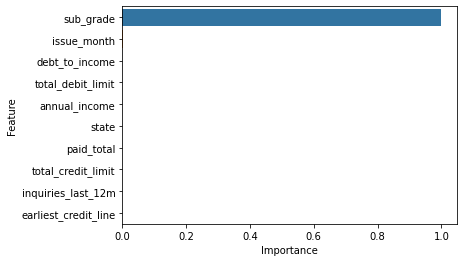

In [322]:
feat = X_train.columns
imp = rf.feature_importances_
feat_df = pd.DataFrame({'Feature': feat, 'Importance': imp})
feat_df = feat_df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=feat_df);

In [323]:
regressor = Sequential()
regressor.add(Dense(100, input_dim=41, kernel_initializer='normal', activation='relu'))
regressor.add(Dense(20, kernel_initializer='normal', activation='relu'))
regressor.add(Dense(1, kernel_initializer='normal'))
regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               4200      
                                                                 
 dense_13 (Dense)            (None, 20)                2020      
                                                                 
 dense_14 (Dense)            (None, 1)                 21        
                                                                 
Total params: 6,241
Trainable params: 6,241
Non-trainable params: 0
_________________________________________________________________


In [324]:
sc_ann = StandardScaler()
X_train = sc_ann.fit_transform(X_train)
X_test = sc_ann.transform(X_test)

In [ ]:
history = regressor.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_test, y_test))

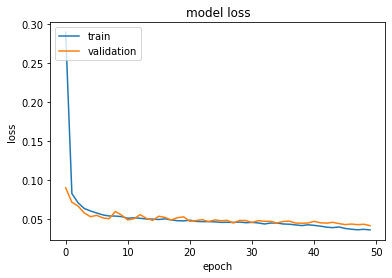

In [326]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [327]:
y_pred = regressor.predict(X_test)
error = metrics.mean_squared_error(sc.inverse_transform(y_test), sc.inverse_transform(y_pred), squared=False)
print('Root Mean Squared Error: ',round(error,3))
print('Mean Absolute Error: ',round(metrics.mean_absolute_error(sc.inverse_transform(y_test), sc.inverse_transform(y_pred)),3))

Root Mean Squared Error:  0.672
Mean Absolute Error:  0.21
